In [2]:
# date: 1/7/2022
# author: Ziwen
# task: veraset - calculate device coverage
import os, sys, gc
import pandas as pd
import numpy as np
import yaml
import os
import glob
import ipystata

from google.cloud import storage
from google.cloud import bigquery

path = os.path.expanduser('~')
# set up env credential variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path + '/Dropbox/Amenity/source/analysis/veraset_gravy_gps_sample/firm-exit-3608acd14b06.json'
client = bigquery.Client()

import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Identify Home/work location using visitation data
The idea is that since veraset aggregate raw pings to stays, for each home stay in visitation data, there's gotta be some corresponding pings dropped at home in raw ping data. Here's the method
1. For all home stays in visitation, take their caid and start timestamp
2. match back to raw pings using caid and time stamp
3. take the average lat and lon of such pings for each device as their home location
4. and the same for work locations.

In [2]:
# upload data from local to bq - home stay caid and timestamp from visitation
destination_table = 'firm-exit.veraset_visits.visitation_home_stay'

file_path = path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/identify_homework_location_visits_to_raw/id_timestamp_home.csv'
table_id = destination_table
job_config_upload = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True, write_disposition='WRITE_TRUNCATE',
    )

with open(file_path, "rb") as source_file:
    job_upload = client.load_table_from_file(source_file, table_id, job_config=job_config_upload)

job_upload.result()  # Waits for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 70173934 rows and 2 columns to firm-exit.veraset_visits.visitation_home_stay


In [3]:
# extract pings matched with visitation home stay caid and start timestamp
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_id_loc_visitation'
job_config_home_visitation = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_home_visitation = f'''
    with home_raw_ping as
    -- select raw pings by matching caid and timestamp, and take lat & lon of those pings
    (select
    -- necessary variables and calculation
        `ping_ca_01`.`caid` as caid, 
        `ping_ca_01`.`utc_timestamp` as utc_timestamp,
        `ping_ca_01`.`latitude` as lat,
        `ping_ca_01`.`longitude` as lon
    from `ping_ca_01`
    inner join `visitation_home_stay`
    on `ping_ca_01`.`caid` = `visitation_home_stay`.`caid` and `ping_ca_01`.`utc_timestamp` = `visitation_home_stay`.`utc_timestamp`
    )
    select
        caid as caid,
        avg(lat) as avg_lat,
        avg(lon) as avg_lon
    from home_raw_ping
    group by caid
'''

query_job_home_visitation = client.query(query_home_visitation, job_config=job_config_home_visitation)
query_job_home_visitation.result() 

In [4]:
home_id_loc_visitation = query_job_home_visitation.to_dataframe()

home_id_loc_visitation.to_csv(path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/home_id_loc_visitation.csv', sep=',', mode='w')

## Compare reverse engineering result from our imputation
the general idea is to look at raw pings at veraset home locations and our home locations side by side and find what's the divergence.

In [3]:
# extract reverse eng results with our imputation
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.rev_our_compare'
job_config_rev_our_compare = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_rev_our_compare = f'''
    with subsample_rev_our as 
    (select
        device_id as caid,
        geohash7 as our_geohash7,
        geohash as rev_geohash7
    from `home_location_geohash7`
    -- which contains devices for which our home differs from rev home
    limit 1000
    ), raw_ping as 
    -- to extract the raw ping at our home and rev home of those 1000 people
    (select 
        `ping_ca_01`.caid as caid, 
        datetime_sub(timestamp_seconds(`ping_ca_01`.utc_timestamp), interval 7 hour) as PDT_time,
        substr(`ping_ca_01`.geo_hash, 1, 7) as raw_geohash7,
        `ping_ca_01`.latitude as lat,
        `ping_ca_01`.longitude as lon,
        subsample_rev_our.our_geohash7 as our_geohash7,
        subsample_rev_our.rev_geohash7 as rev_geohash7
    from `ping_ca_01`
    inner join subsample_rev_our
    on subsample_rev_our.caid = `ping_ca_01`.caid
    )
    select
        *
    from 
    (select
        *,
        case
            when our_geohash7 = raw_geohash7 then 1
            else 0
        end
        as our_home,
        case
            when rev_geohash7 = raw_geohash7 then 1
            else 0
        end
        as rev_home
    from raw_ping
    )
    where our_home = 1 or rev_home = 1
    order by caid, PDT_time
'''

query_job_rev_our_compare = client.query(query_rev_our_compare, job_config=job_config_rev_our_compare)
query_job_rev_our_compare.result() 

In [4]:
rev_our_compare = query_job_rev_our_compare.to_dataframe()

rev_our_compare.to_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/identify_homework_location_visits_to_raw/rev_our_compare.csv', sep=',', mode='w')

rev_our_compare = pd.read_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/identify_homework_location_visits_to_raw/rev_our_compare.csv', sep=',')

<BarContainer object of 24 artists>

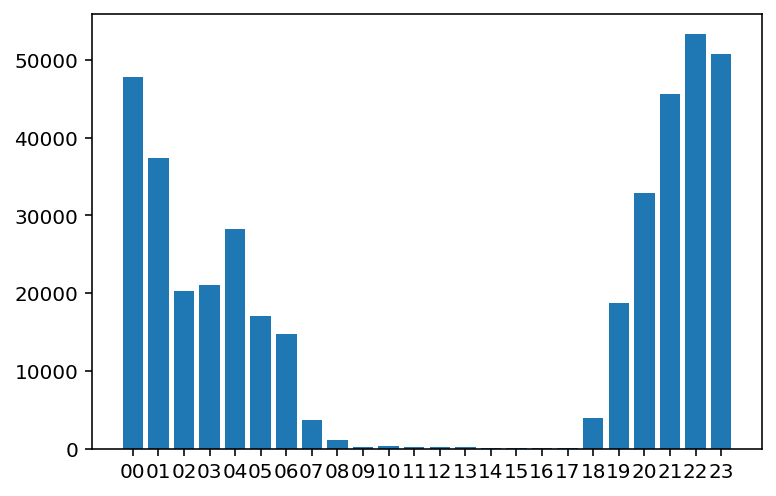

In [29]:
rev_our_compare['hofd']=rev_our_compare['PDT_time'].apply(lambda x: x[11:13])
our_hofd = rev_our_compare[rev_our_compare['our_home']==1].groupby('hofd').count()

plt.bar(our_hofd.index,our_hofd['caid'] )

<BarContainer object of 24 artists>

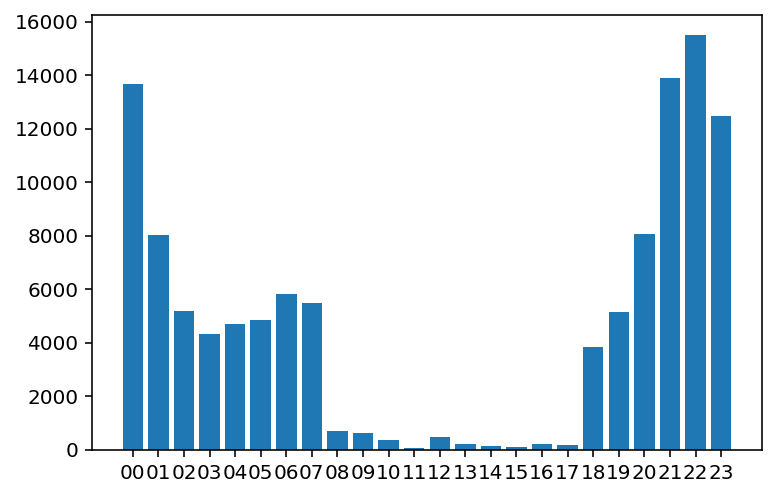

In [30]:
rev_our_compare['hofd']=rev_our_compare['PDT_time'].apply(lambda x: x[11:13])
rev_hofd = rev_our_compare[rev_our_compare['rev_home']==1].groupby('hofd').count()

plt.bar(rev_hofd.index,rev_hofd['caid'] )